In [29]:
import sys
from datetime import datetime

import gymnasium as gym
import numpy as np
import wandb
from stable_baselines3 import *
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.logger import HumanOutputFormat
from stable_baselines3.common.logger import Logger as SB3Logger

import sinergym
from sinergym.utils.callbacks import *
from sinergym.utils.constants import *
from sinergym.utils.logger import WandBOutputFormat
from sinergym.utils.rewards import *
from sinergym.utils.wrappers import *

In [30]:
from stable_baselines3.common.env_util import make_vec_env

In [31]:
# Environment ID
environment = 'Eplus-5zone-mixed-continuous-stochastic-v1'

# Training episodes
episodes = 10

# Name of the experiment
experiment_date = datetime.today().strftime('%Y-%m-%d_%H:%M')
experiment_name = '5Z_RB_' + environment + \
    '-episodes-' + str(episodes)
experiment_name += '_' + experiment_date

In [32]:
extra_conf = {
    'timesteps_per_hour': 6,
    'runperiod': (1, 4, 2024, 1, 3, 2025),
}

In [33]:
env = gym.make(environment,
               env_name=experiment_name,
               weather_files=["JPN_Nagoya.476350_IWEC.epw"],
               reward=ExpReward,
               reward_kwargs = {
                   "energy_weight": 0.5,
                   'temperature_variables': ['air_temperature'],
                   'energy_variables': ['HVAC_electricity_demand_rate'],
                   "range_comfort_winter": (18.0, 28.0),
                   "range_comfort_summer": (18.0, 28.0),
                   "lambda_energy": 0.0001,
               },
              building_config=extra_conf,)

eval_env = gym.make(environment,
                    env_name=experiment_name+'_EVALUATION',
                    weather_files=["JPN_Nagoya.476350_IWEC.epw"],
                    reward=ExpReward,
                    reward_kwargs = {
                        "energy_weight": 0.5,
                        'temperature_variables': ['air_temperature'],
                        'energy_variables': ['HVAC_electricity_demand_rate'],
                        "range_comfort_winter": (18.0, 28.0),
                        "range_comfort_summer": (18.0, 28.0),
                        "lambda_energy": 0.0001,
                    },
                   building_config=extra_conf,)

#==============================================================================================#    
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                                
[ENVIRONMENT] (INFO) : Name: 5Z_RB_Eplus-5zone-mixed-continuous-stochastic-v1-episodes-10_2025-08-14_22:52
#==============================================================================================#  
[MODEL] (INFO) : Working directory created: /workspace/5Z_RB_Eplus-5zone-mixed-continuous-stochastic-v1-episodes-10_2025-08-14_22:52-res1
[MODEL] (INFO) : Model Config is correct.                                             
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.  
[MODEL] (INFO) : Updated building model Output:Meter with meter names.                
[MODEL] (INFO) : Building configuration: runperiod updated to {'start_day': 1, 'start_month': 4, 'start_year': 2024, 'end_day': 1, 'end_month': 3, 'end_year': 2025, 'start_weekday': 1, 'n_steps_per_hour': 6}

In [34]:
env = LoggerWrapper(env)
env = CSVLogger(env)

[WRAPPER LoggerWrapper] (INFO) : Wrapper initialized.                                 
[WRAPPER CSVLogger] (INFO) : Wrapper initialized.                                     
Simulation Progress [Episode 11]: 100%|██████████| 100/100 [10:18<00:00,  6.19s/%, 100% completed]

In [35]:
# 下のリンクより引用。ただし、setpointだけ変更してある。
# https://github.com/ugr-sail/sinergym/blob/main/sinergym/utils/controllers.py
class RBC5Zone(object):
    def __init__(self, env: Env) -> None:
        """Agent based on static rules for controlling 5ZoneAutoDXVAV setpoints.
        Based on ASHRAE Standard 55-2004: Thermal Environmental Conditions for Human Occupancy.

        Args:
            env (Env): Simulation environment
        """

        self.env = env

        self.observation_variables = env.get_wrapper_attr(
            'observation_variables')
        self.action_variables = env.get_wrapper_attr('action_variables')

        self.setpoints_summer = np.array((18.0, 28.0), dtype=np.float32)
        self.setpoints_winter = np.array((18.0, 28.0), dtype=np.float32)

    def act(self, observation: List[Any]) -> np.ndarray:
        """Select action based on indoor temperature.

        Args:
            observation (List[Any]): Perceived observation.

        Returns:
            np.ndarray: Action chosen.
        """
        obs_dict = dict(zip(self.observation_variables, observation))
        year = int(obs_dict['year']) if obs_dict.get('year', False) else YEAR
        month = int(obs_dict['month'])
        day = int(obs_dict['day_of_month'])

        summer_start_date = datetime(year, 6, 1)
        summer_final_date = datetime(year, 9, 30)

        try:
            current_dt = datetime(year, month, day)
        except ValueError:
            print(month)

        # Get season comfort range
        if current_dt >= summer_start_date and current_dt <= summer_final_date:  # pragma: no cover
            season_range = self.setpoints_summer
        else:  # pragma: no cover
            season_range = self.setpoints_winter

        return season_range


In [36]:
# Create rule-based controller
agent = RBC5Zone(env)

for i in range(episodes):
    obs, info = env.reset()
    rewards = []
    obs_dict = dict(zip(env.get_wrapper_attr(
            'observation_variables'), obs))
    truncated = terminated = False
    while not (terminated or truncated):
        action = agent.act(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
    print(
        'Episode ',
        i,
        'Mean reward: ',
        np.mean(rewards),
        'Cumulative reward: ',
        sum(rewards))

#env.reset()
env.close()

Simulation Progress [Episode 11]: 100%|██████████| 100/100 [10:20<00:00,  6.20s/%, 100% completed]
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: 5Z_RB_Eplus-5zone-mixed-continuous-stochastic-v1-episodes-10_2025-08-14_22:52
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file JPN_Nagoya.476350_IWEC.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[MODEL] (INFO) : Weather noise applied to columns: ['Dry Bulb Temperature']
[ENVIRONMENT] (INFO) : Saving episode output path in /workspace/5Z_RB_Eplus-5zone-mixed-continuous-stochastic-v1-episodes-10_2025-08-14_22:52-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Ep

In [37]:
import matplotlib.pyplot as plt
import csv
import numpy as np

In [38]:
with open("5Z_RB_Eplus-5zone-mixed-continuous-stochastic-v1-episodes-10_2025-08-14_22:52-res1/progress.csv") as f:
    reader = csv.DictReader(f)
    mean_rewards = []
    mean_comforts = []
    mean_energys = []
    for row in reader:
        mean_rewards.append(float(row["mean_reward"]))
        mean_comforts.append(float(row["mean_reward_comfort_term"]))
        mean_energys.append(float(row["mean_reward_energy_term"]))

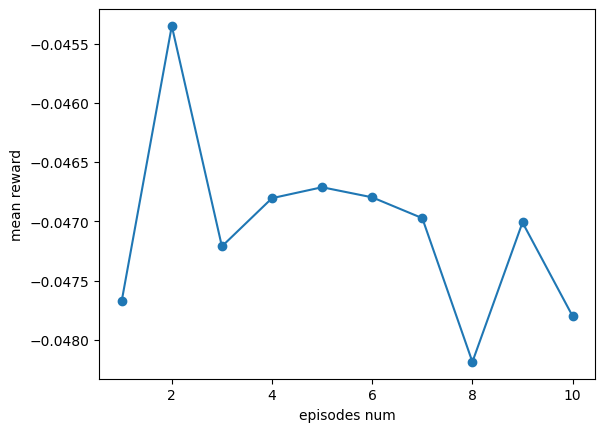

In [39]:
episodes = 10
plt.plot(np.arange(1,episodes+1,1), mean_rewards, marker="o")
plt.xlabel("episodes num")
plt.ylabel("mean reward")
plt.show()

In [42]:
with open("5Z_RB_Eplus-5zone-mixed-continuous-stochastic-v1-episodes-10_2025-08-14_22:52-res1/progress.csv") as f:
    reader = csv.DictReader(f)
    mean_rewards = []
    mean_comforts = []
    mean_energys = []
    for row in reader:
        mean_rewards.append(float(row["mean_reward"]))
        mean_comforts.append(float(row["mean_reward_comfort_term"]))
        mean_energys.append(float(row["mean_reward_energy_term"]))

In [43]:
evals = 10

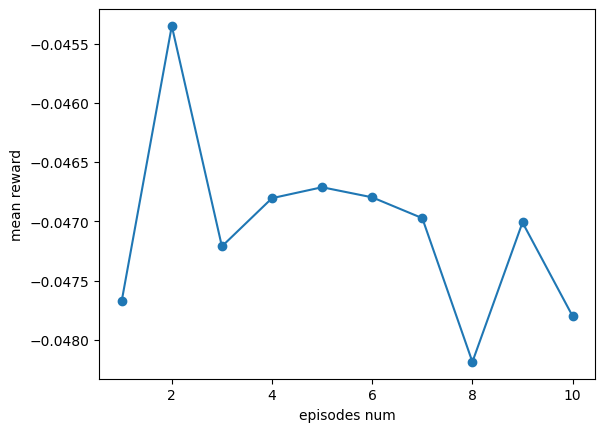

In [44]:
plt.plot(np.arange(1,evals+1,1), mean_rewards, marker="o")
plt.xlabel("episodes num")
plt.ylabel("mean reward")
plt.show()

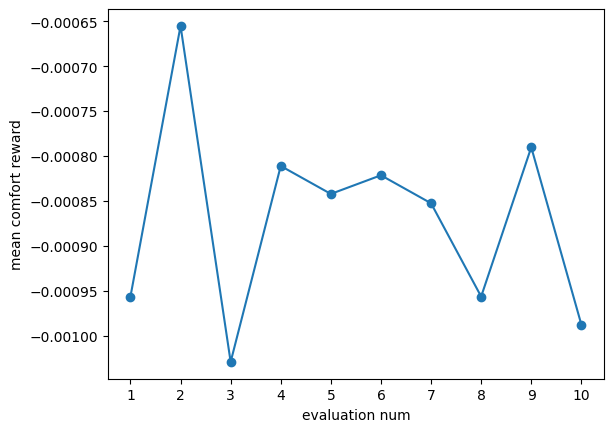

In [45]:
plt.plot(np.arange(1, evals+1, 1), mean_comforts, marker="o")
plt.xlabel("evaluation num")
plt.ylabel("mean comfort reward")
plt.xticks(np.arange(1,11,1))
plt.show()

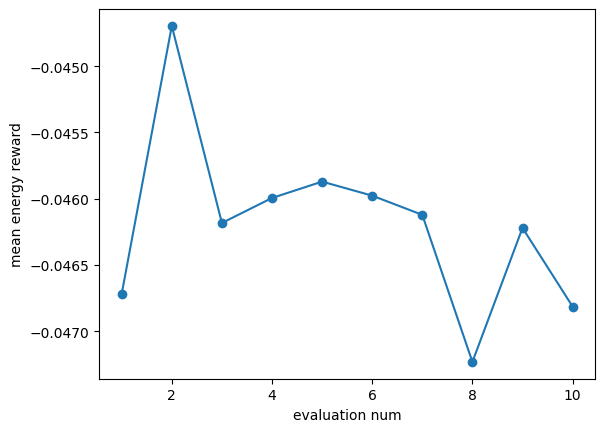

In [46]:
plt.plot(np.arange(1,evals+1,1), mean_energys, marker="o")
plt.xlabel("evaluation num")
plt.ylabel("mean energy reward")
plt.show()